In [1]:
from rec.models.mnist_vae import MNISTVAE

import tensorflow as tf
tfl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
save_dir = "../../../../models/relative-entropy-coding/snis-experiments/gaussian"

In [3]:
gauss_vae = MNISTVAE(prior=tfd.Normal(loc=tf.zeros(50), scale=tf.ones(50)),
                     latents=50)

optimizer = tf.optimizers.Adam(1e-4)

ckpt = tf.train.Checkpoint(step=tf.Variable(1, dtype=tf.int64),
                           optimizer=optimizer,
                           model=gauss_vae)

manager = tf.train.CheckpointManager(ckpt, save_dir, max_to_keep=3)

status = ckpt.restore(manager.latest_checkpoint)

if manager.latest_checkpoint:
    print(f"Restored {manager.latest_checkpoint}")

Restored ../../../../models/relative-entropy-coding/snis-experiments/gaussian/ckpt-16


In [4]:
dataset = tfds.load("binarized_mnist",
                    data_dir="/scratch/gf332/datasets/binarized_mnist")

test_ds = dataset["test"]

test_ds = test_ds.map(lambda x: tf.cast(x["image"], tf.float32))

tf.Tensor(-826.24445, shape=(), dtype=float32)


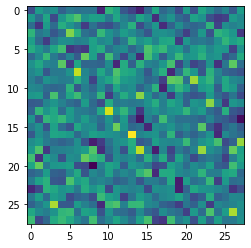

In [5]:
K = 50

for i in test_ds.take(1):
    plt.imshow(gauss_vae(i[None, ...])[0,...,0])
    
    samples = tf.reshape(gauss_vae.posterior.sample(K), [K, -1])
    
    post_prob = gauss_vae.posterior.log_prob(samples)
    post_prob = tf.reduce_sum(post_prob, axis=1)
    
    prior_prob = gauss_vae.prior.log_prob(samples)
    prior_prob = tf.reduce_sum(prior_prob, axis=1)
    
    likelihood_loc = gauss_vae.decoder(samples)
    likelihood_dist = tfd.Normal(loc=likelihood_loc, scale=1.)
    
    likelihood = likelihood_dist.log_prob(i)
    likelihood = tf.einsum("ijkl -> i", likelihood)

    log_weights = prior_prob + likelihood - post_prob
    
    log_lik = tf.reduce_logsumexp(log_weights)
    log_lik = log_lik - tf.math.log(tf.cast(K, tf.float32))
    
    print(log_lik)